### Astrobase core stuff

This notebook describes how to use the the `hatlc`, `periodbase`, and `plotbase` modules to read in HAT light curves, run period searches, and plot the results. The `nb-data` subdirectory in the `notebooks` folder contains some sample HAT light curves to use for this work.

## Importing modules

In [ ]:
%matplotlib inline
import numpy as np
from astrobase import periodbase, checkplot
from astrobase.hatsurveys import hatlc

## Reading HAT light curves

In [2]:
ls nb-data

HAT-579-0051858-V0-DR0-e867e20a15f25116548f6cdf8d5105f2-hatlc.csv.gz
HAT-772-0554686-V0-DR0-hatlc.sqlite.gz
HAT-777-0058978-V0-DR0-hatlc.sqlite.gz
test-checkplot.pkl
test-checkplot.png
test-twolsp-checkplot.png


There are two types of light curves `hatlc.py` can read. 

The first is a 'sqlitecurve' (`-hatlc.sqlite.gz`), which is the canonical form of light curve produced by the new generation HAT data server. This is a gzipped [SQLite3](http://sqlite.org) database file containing the light curve columns and all metadata. We use this format because it's easy to access, update, and filter based on normal SQL queries. 

The second format is a gzipped CSV text file (`-hatlc.csv.gz`). This contains the same data as the sqlitecurve, but in ASCII text format. This is the default public light curve format, and should be straightforward to read and manipulate using standard Unix tools. It also contains an extensive metadata header that effectively makes the file self-describing.

Below, we look at reading both types of light curves.

In [3]:
# reading CSV light curves
lcd = hatlc.read_csvlc('nb-data/HAT-579-0051858-V0-DR0-e867e20a15f25116548f6cdf8d5105f2-hatlc.csv.gz')

[2018-01-20T23:53:09Z - INFO] reading gzipped HATLC: nb-data/HAT-579-0051858-V0-DR0-e867e20a15f25116548f6cdf8d5105f2-hatlc.csv.gz


In [4]:
# we can get a description of the light curve using the hatlc.describe function
hatlc.describe(lcd)

OBJECT
------

objectid = HAT-579-0051858
hatid = HAT-579-0051858; twomassid = 19394601-2544539
network = HS; stations = HS01,HS03,HS05; ndet = 10564

ra = 294.941746; decl = -25.748318
pmra = -9.3; pmra_err = 2.6
pmdecl = -7.6; pmdecl_err = 2.6

jmag = 13.098; hmag = 12.779; kmag = 12.661; bmag = nan; vmag = nan
sdssg = nan; sdssr = nan; sdssi = nan

METADATA
--------

datarelease = 0; lcversion = 0
lastupdated = 1445483599.116; lcserver = 8ad6d6a
comment = initial HS lightcurve creation
lcbestaperture = {"ap": ["002"], "ism": ["002"]}
lcsortcol = rjd
lcfiltersql = 
lcnormcols = 

CAMFILTERS
----------

4 - r - Sloan r AST0285
12 - r - Sloan r SN070 AST0285
20 - r - Sloan r SN078 AST0285

PHOTAPERTURES
-------------

000 - 2.05 px
001 - 3.00 px
002 - 4.00 px

LIGHT CURVE COLUMNS
-------------------

000 - rjd - time of observation in Reduced Julian date (JD = 2400000.0 + RJD)
001 - bjd - time of observation in Baryocentric Julian date (note: this is BJD_TDB)
002 - net - network of tel

In [5]:
# reading sqlitecurves 
# this returns a dict with the light curve columns and info 
# and a message indicating status of the LC read operation
lcd, msg = hatlc.read_and_filter_sqlitecurve('nb-data/HAT-772-0554686-V0-DR0-hatlc.sqlite.gz')

In [6]:
# we can get a description of the light curve using the hatlc.describe function
hatlc.describe(lcd)

OBJECT
------

objectid = HAT-772-0554686
hatid = HAT-772-0554686; twomassid = 14374811-5648595
network = HS; stations = HS02,HS04,HS06; ndet = 11261

ra = 219.450491; decl = -56.816551
pmra = 3.6; pmra_err = 2.9
pmdecl = -6.2; pmdecl_err = 2.9

jmag = 13.303; hmag = 12.65; kmag = 12.461; bmag = 17.744; vmag = 16.083
sdssg = 16.867; sdssr = 15.648; sdssi = 14.909

METADATA
--------

datarelease = 0; lcversion = 0
lastupdated = 1479866909.288; lcserver = 5b81c8c
comment = initial HS lightcurve creation
lcbestaperture = {"ap": ["002"], "ism": ["002"]}
lcsortcol = rjd
lcfiltersql = 
lcnormcols = 

CAMFILTERS
----------

7 - r - Sloan r AST0285
15 - r - Sloan r SN073 AST0285
23 - r - Sloan r SN081 AST0285

PHOTAPERTURES
-------------

000 - 2.05 px
001 - 3.00 px
002 - 4.00 px

LIGHT CURVE COLUMNS
-------------------

000 - rjd - time of observation in Reduced Julian date (JD = 2400000.0 + RJD)
001 - bjd - time of observation in Baryocentric Julian date (note: this is BJD_TDB)
002 - net - n

In [7]:
# in both cases, the columns are all numpy arrays
lcd['rjd']

array([ 56092.6405579,  56092.6463396,  56140.5295653, ...,  56920.4836559,
        56920.8740464,  56921.4836334])

In [8]:
print(lcd['stf'].size)

11261


In [9]:
# it's possible to filter easily using SQL query syntax
# e.g. let's get only those observations of this object 
# that were taken by HATSouth stations 2 (LCO) and 6 (SSO)
lcd, msg = hatlc.read_and_filter_sqlitecurve('nb-data/HAT-772-0554686-V0-DR0-hatlc.sqlite.gz',
                                             sqlfilters='(stf = 2) or (stf = 6)')

[2018-01-20T23:53:25Z - INFO] filtering LC using: (stf = 2) or (stf = 6)


In [10]:
# make sure we filtered everything right
print(lcd['stf'].size, np.unique(lcd['stf']))

6611 [2 6]


In [11]:
# let's read in the full LC for the operations below
lcd, msg = hatlc.read_and_filter_sqlitecurve('nb-data/HAT-772-0554686-V0-DR0-hatlc.sqlite.gz')

## Running period finding operations

In [12]:
# first, we normalize the light curve, i.e. make sure all observations 
# are at the same zero-point. this is usually required for very long 
# time-base HATNet light curves since these include different instrument 
# combinations over the decade of survey operations.
normlcd = hatlc.normalize_lcdict(lcd)

/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
# next, break out the columns we'll use for the period-finding
# we'll use reduced JD as the times, 
# EPD magnitude in the smallest aperture as the mags, 
# and magnitude errors in the smallest aperture as the errs
times, mags, errs = normlcd['rjd'], normlcd['aep_000'], normlcd['aie_000']

In [14]:
# let's run Lomb-Scargle
glsp = periodbase.pgen_lsp(times,mags,errs)

[2018-01-20T23:53:42Z - INFO] using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
[2018-01-20T23:53:42Z - INFO] using 8 workers...


In [15]:
# let's make a checkplot to see the periods associated with the 
# best spectrogram peaks. this also gives a quick overview of the 
# object information and gets a finder chart from NASA's SkyView service 
# if the RA and DEC of the object are present in the objectinfo dict
cp = checkplot.checkplot_png(glsp, times, mags, errs, objectinfo=normlcd['objectinfo'])

[2018-01-20T23:53:52Z - INFO] adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817
[2018-01-20T23:53:52Z - INFO] fetched stamp successfully for (219.450, -56.817)
[2018-01-20T23:53:52Z - INFO] spline fit done. nknots = 30,  chisq = 26855.33159, reduced chisq = 2.54940
[2018-01-20T23:53:52Z - INFO] plotting phased LC with period 1.542895, epoch 56853.36014
[2018-01-20T23:53:53Z - INFO] plotting phased LC with period 0.771447, epoch 56853.36014
[2018-01-20T23:53:54Z - INFO] plotting phased LC with period 3.085790, epoch 56853.36014
[2018-01-20T23:53:54Z - INFO] plotting phased LC with period 0.771447, epoch 56853.36014
[2018-01-20T23:53:55Z - INFO] plotting phased LC with period 0.514234, epoch 56853.36014
[2018-01-20T23:53:55Z - INFO] plotting phased LC with period 3.085790, epoch 56853.36014
[2018-01-20T23:53:56Z - INFO] plotting phased LC with period 0.385473, epoch 56853.36014


/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


[2018-01-20T23:54:00Z - INFO] checkplot done -> checkplot.png


In [16]:
# to see the checkplot, let's use ipython's built in image viewer
from IPython.display import Image

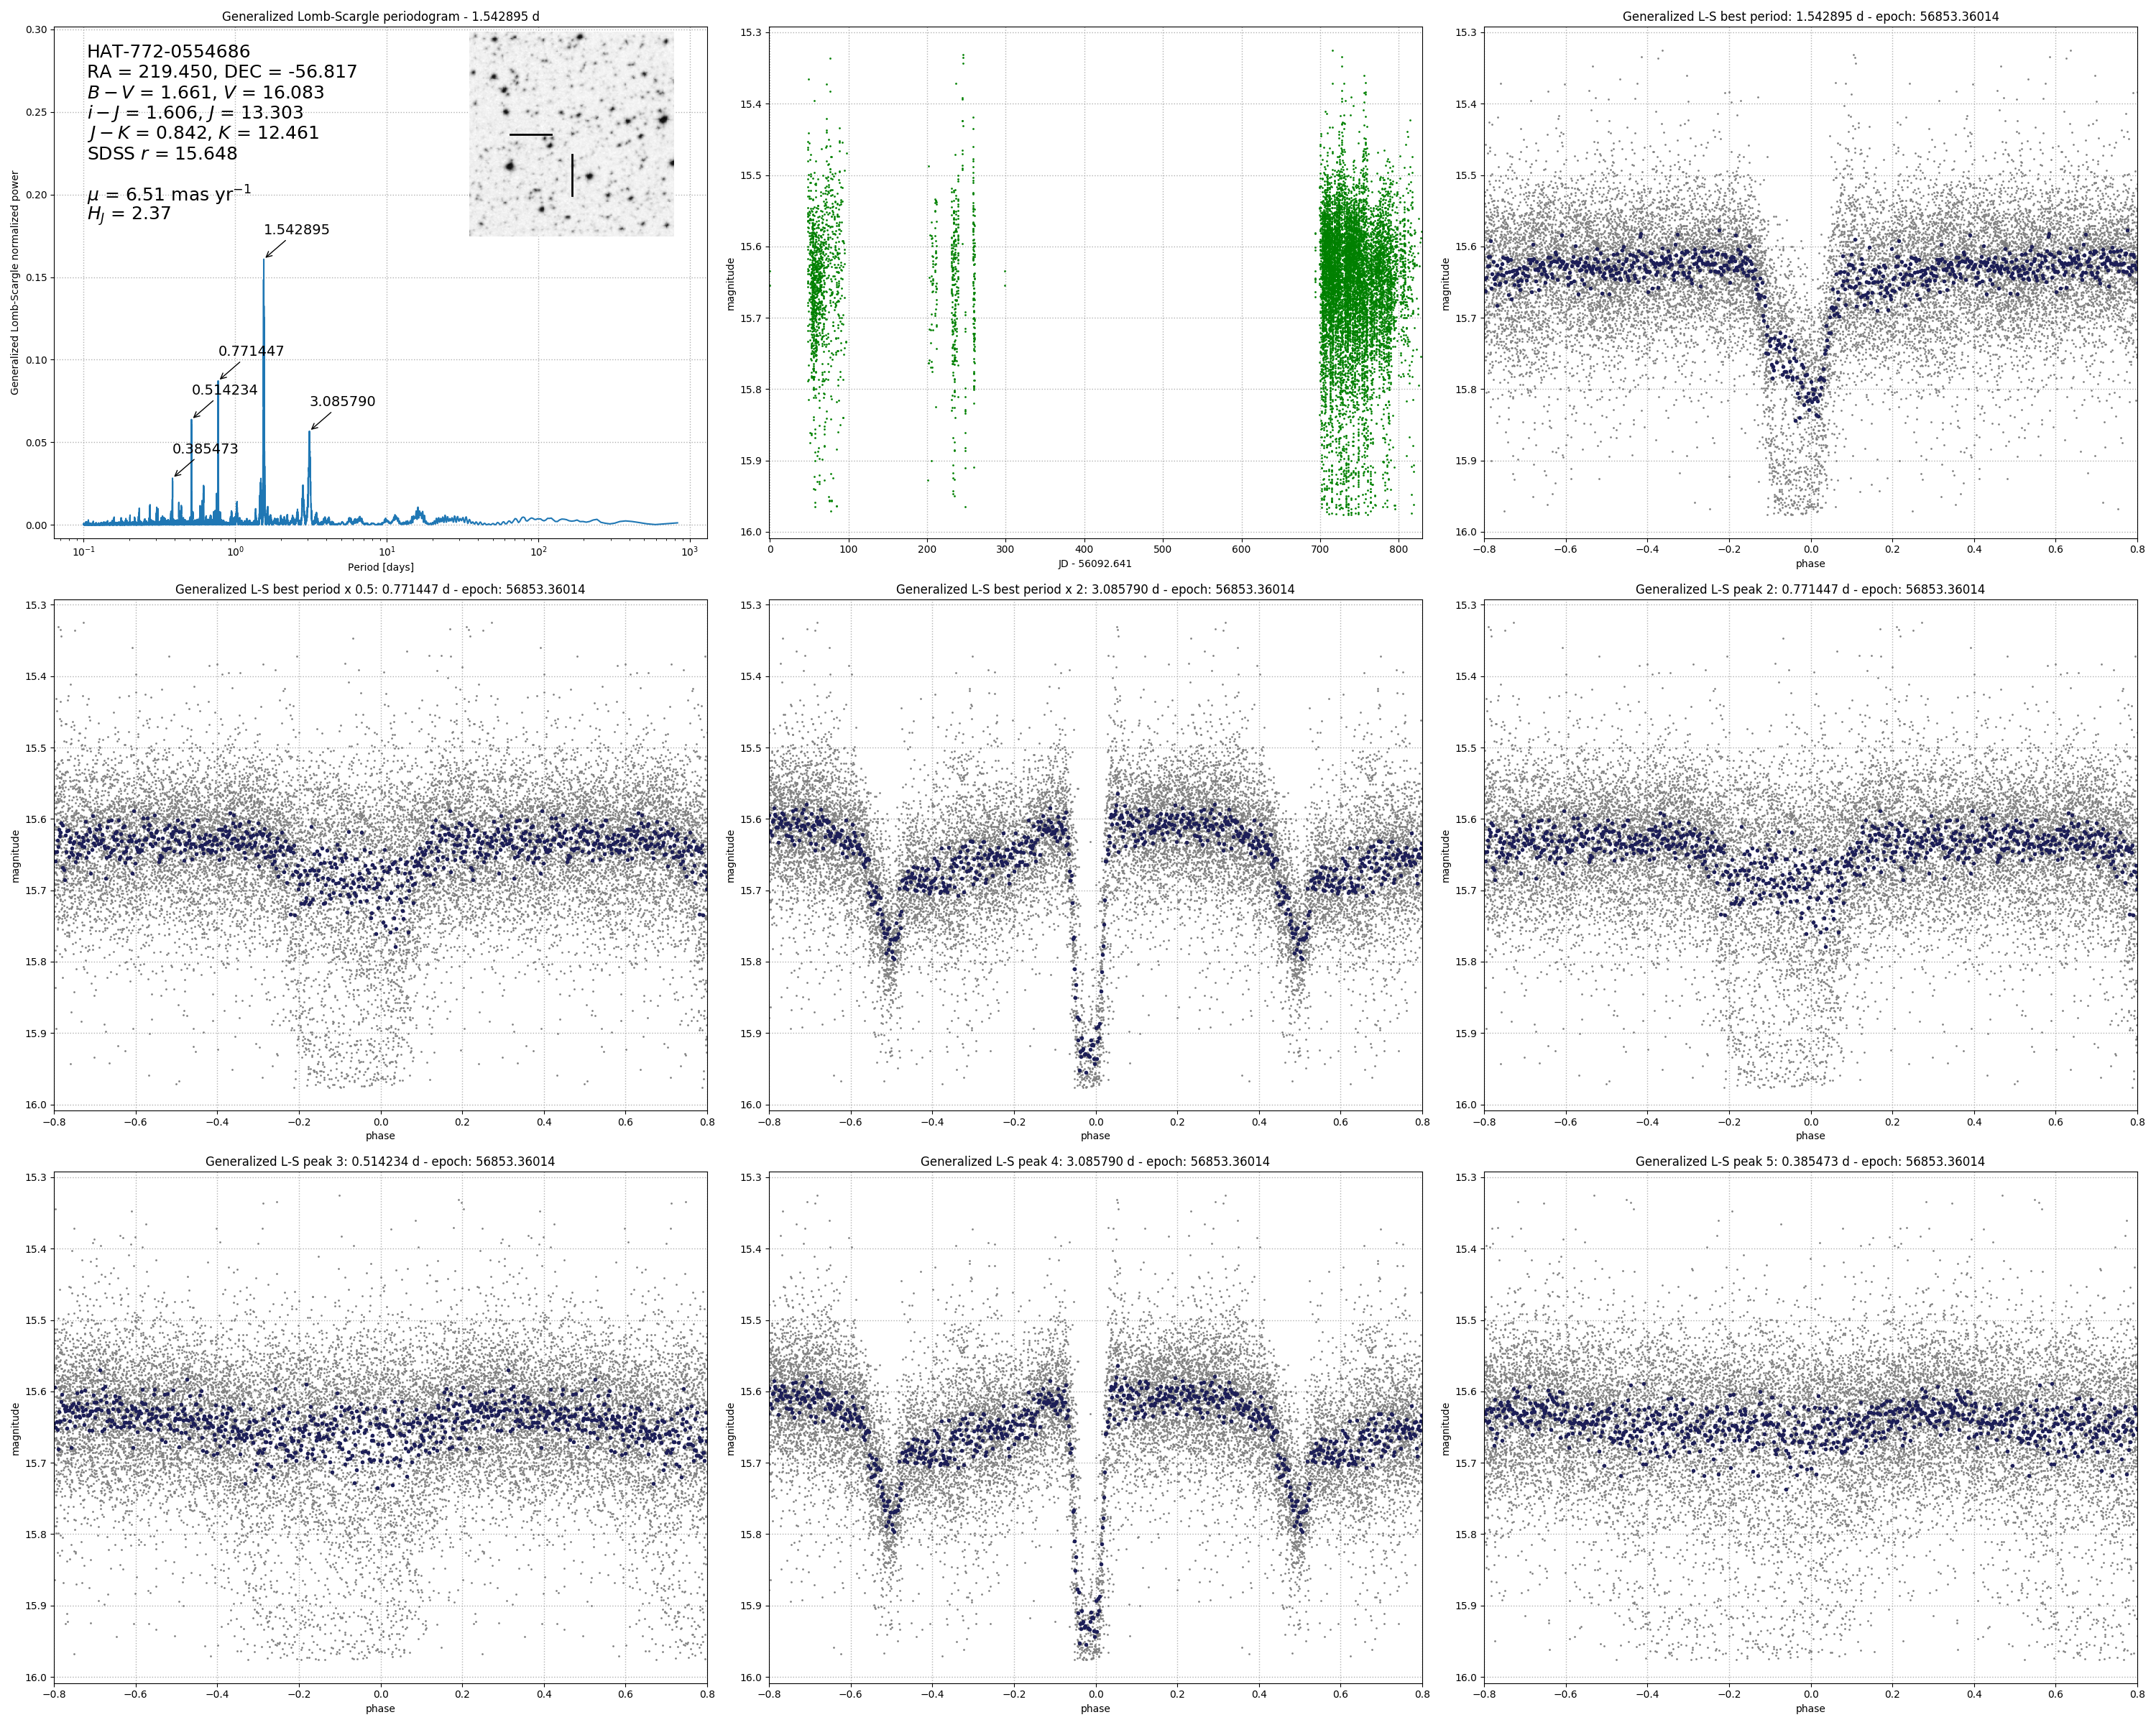

In [17]:
Image('checkplot.png')

In [18]:
# the Generalized Lomb-Scargle usually gets the period wrong for 
# eclipsing binaries as this object appears to be.
# let's try the Stellingwerf Phase-Dispersion Minimization method instead
spdm = periodbase.stellingwerf_pdm(times,mags,errs)

[2018-01-20T23:54:10Z - INFO] using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
[2018-01-20T23:54:10Z - INFO] using 8 workers...


[2018-01-20T23:54:31Z - INFO] adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817
[2018-01-20T23:54:31Z - INFO] fetched stamp successfully for (219.450, -56.817)
[2018-01-20T23:54:31Z - INFO] spline fit done. nknots = 30,  chisq = 20684.76565, reduced chisq = 1.96362
[2018-01-20T23:54:31Z - INFO] plotting phased LC with period 3.085790, epoch 56794.68388
[2018-01-20T23:54:32Z - INFO] plotting phased LC with period 1.542895, epoch 56794.68388
[2018-01-20T23:54:32Z - INFO] plotting phased LC with period 6.171579, epoch 56794.68388
[2018-01-20T23:54:33Z - INFO] plotting phased LC with period 1.542895, epoch 56794.68388
[2018-01-20T23:54:34Z - INFO] plotting phased LC with period 6.157824, epoch 56794.68388
[2018-01-20T23:54:34Z - INFO] plotting phased LC with period 4.630408, epoch 56794.68388
[2018-01-20T23:54:35Z - INFO] plotting phased LC with period 7.717347, epoch 56794.68388


/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


[2018-01-20T23:54:38Z - INFO] checkplot done -> checkplot.png


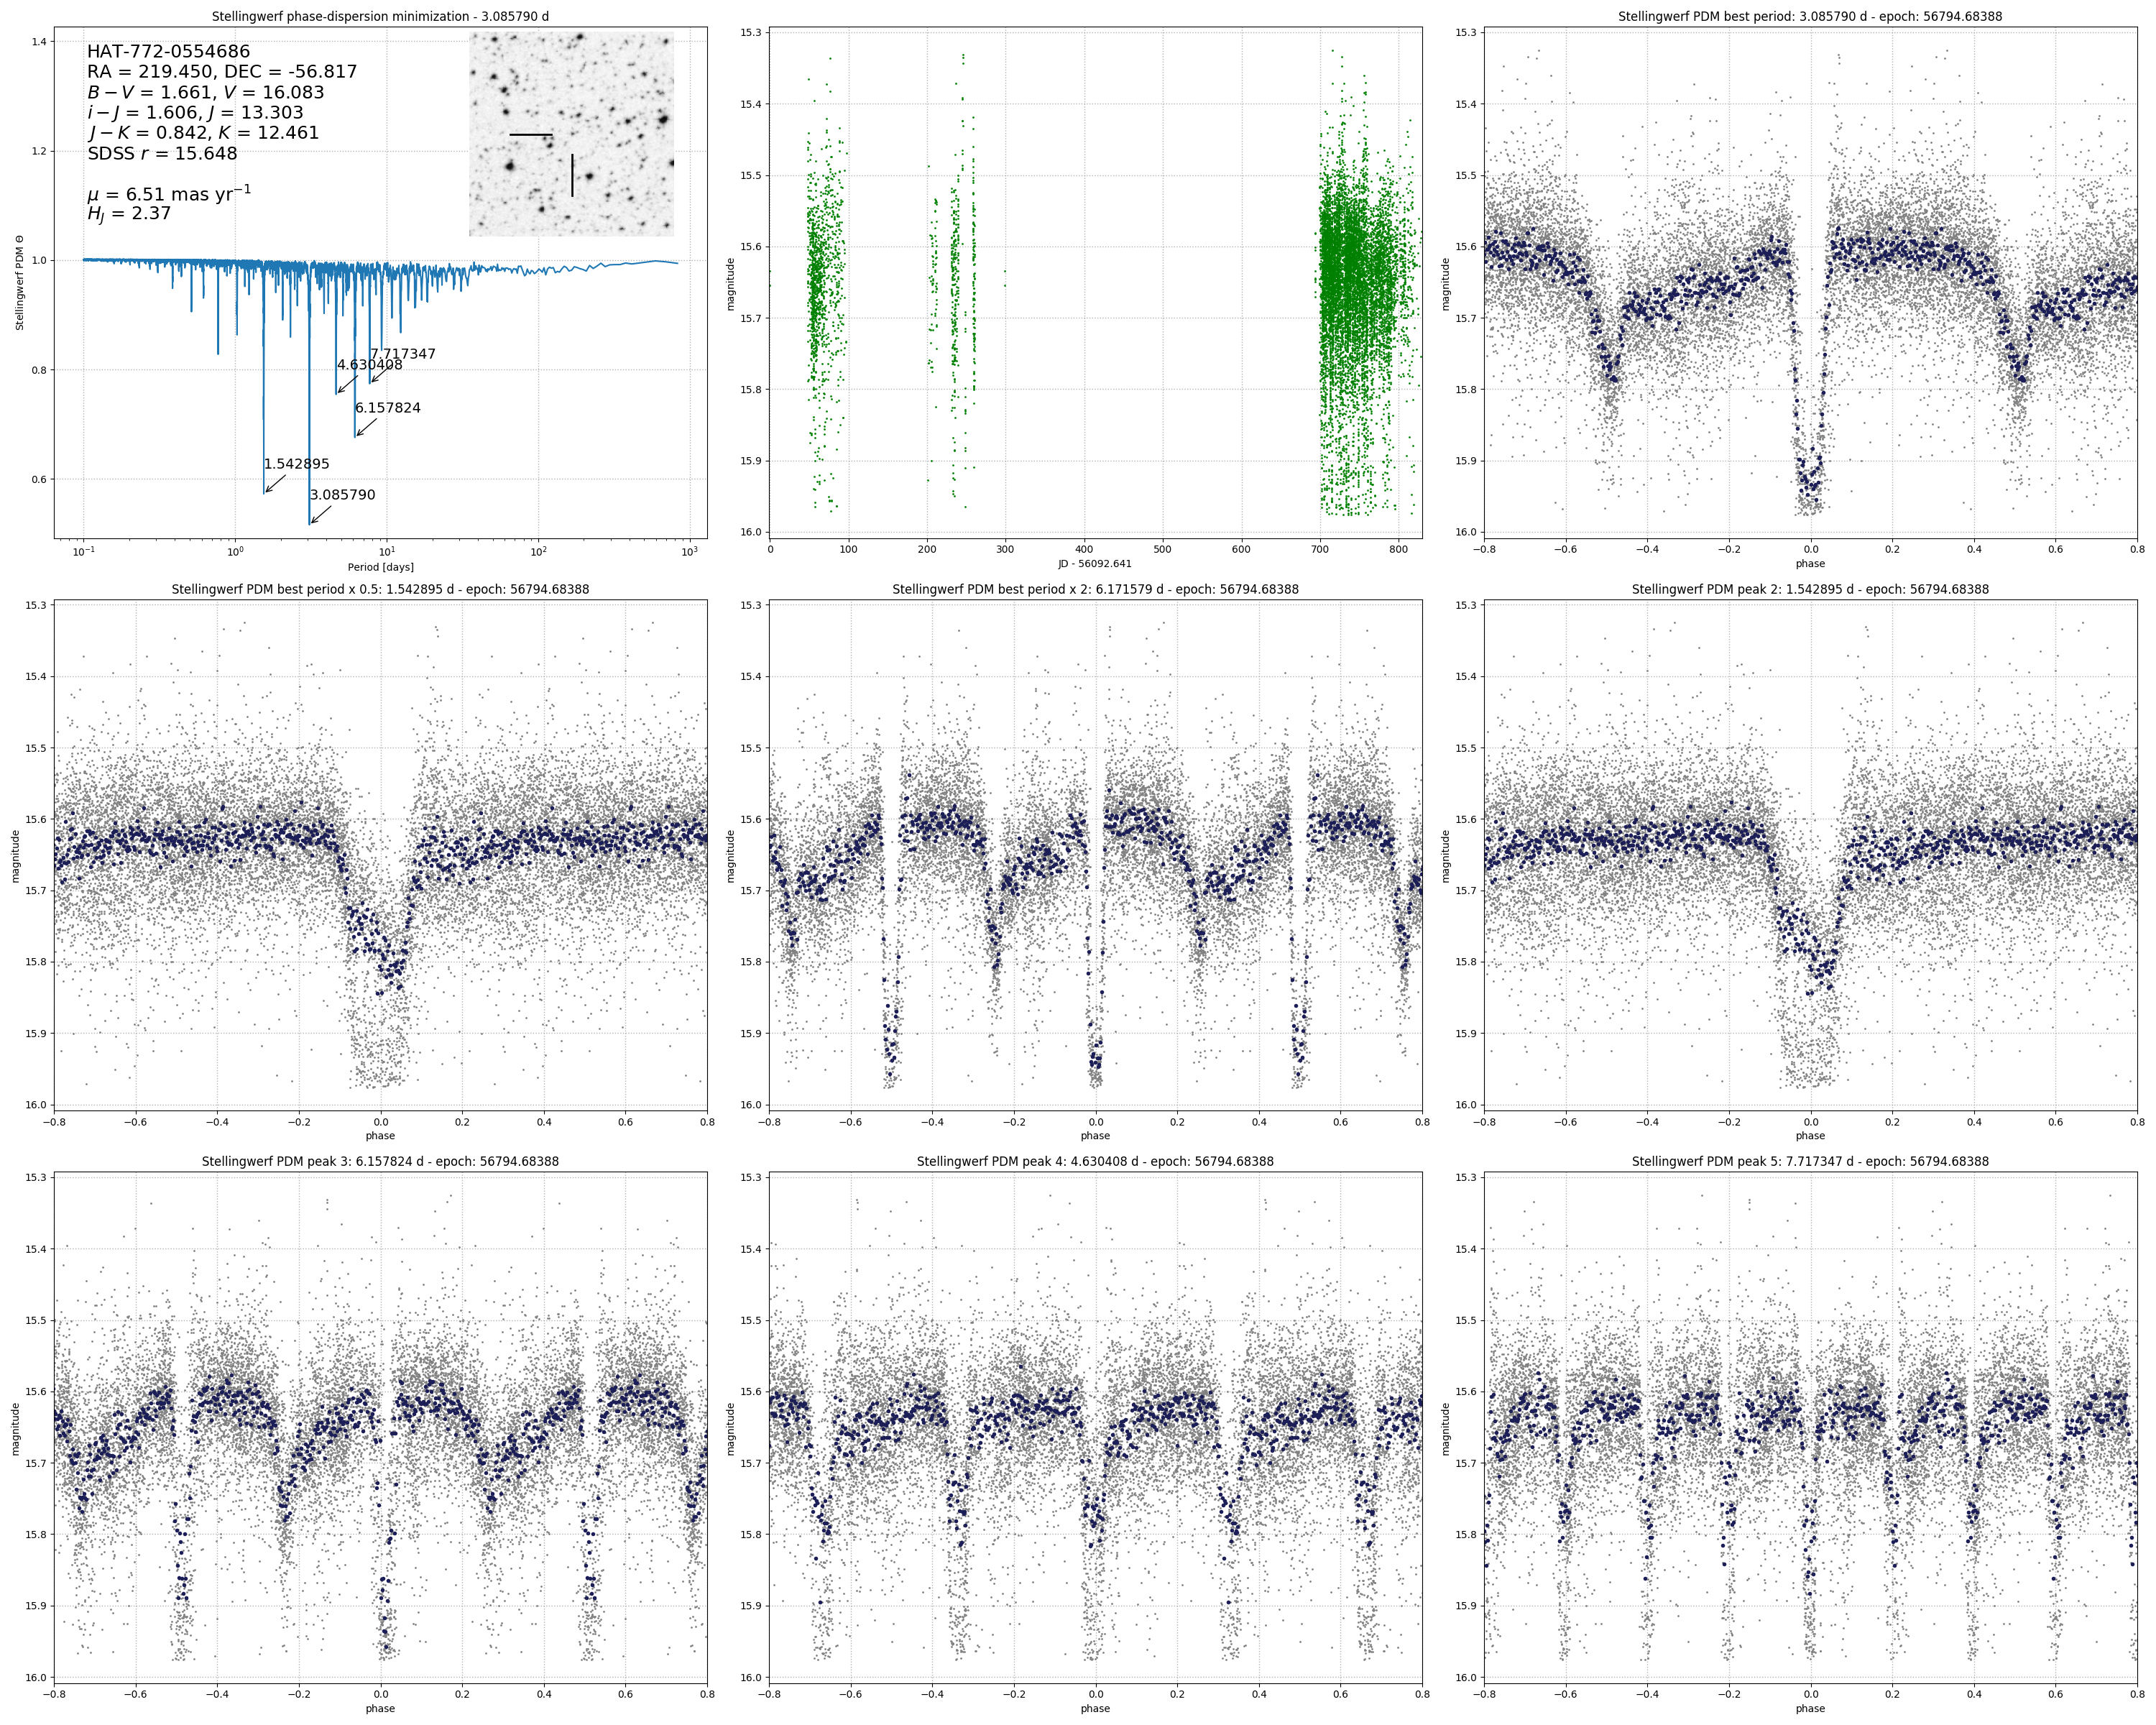

In [19]:
# make the checkplot again
cp = checkplot.checkplot_png(spdm, times, mags, errs, objectinfo=normlcd['objectinfo'])
Image('checkplot.png')

In [20]:
# that looks OK. let's check using the Box-Least-Squares fitting 
# algorithm by Kovacs et al. (2002). 
# this is good for detecting transiting planets and eclipsing binaries.
# let's set the start period to 1.0 days to cut down on 
# the computation we have to do on this poor 8-core machine
blsp = periodbase.bls_parallel_pfind(times,mags,errs,startp=1.0)

[2018-01-20T23:54:46Z - INFO] autofreq: using stepsize: 3.01625250171e-06, min P: 1.0, max P: 100.0, nfreq: 328222, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.8
[2018-01-20T23:54:46Z - INFO] autofreq: minfreq: 0.01, maxfreq: 1.0
[2018-01-20T23:54:46Z - INFO] using 8 workers...
[2018-01-20T23:54:46Z - INFO] worker 1: minfreq = 0.010, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 2: minfreq = 0.134, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 3: minfreq = 0.258, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 4: minfreq = 0.381, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 5: minfreq = 0.505, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 6: minfreq = 0.629, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 7: minfreq = 0.753, nfreqs = 41028
[2018-01-20T23:54:46Z - INFO] worker 8: minfreq = 0.876, nfreqs = 41026
[2018-01-20T23:54:46Z - INFO] running...


[2018-01-20T23:55:19Z - INFO] adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817
[2018-01-20T23:55:19Z - INFO] fetched stamp successfully for (219.450, -56.817)
[2018-01-20T23:55:19Z - INFO] spline fit done. nknots = 30,  chisq = 20235.16310, reduced chisq = 1.92094
[2018-01-20T23:55:19Z - INFO] plotting phased LC with period 3.085607, epoch 56152.86839
[2018-01-20T23:55:19Z - INFO] plotting phased LC with period 1.542756, epoch 56152.86839
[2018-01-20T23:55:20Z - INFO] plotting phased LC with period 6.171077, epoch 56152.86839
[2018-01-20T23:55:21Z - INFO] plotting phased LC with period 3.085790, epoch 56152.86839
[2018-01-20T23:55:21Z - INFO] plotting phased LC with period 1.542895, epoch 56152.86839
[2018-01-20T23:55:22Z - INFO] plotting phased LC with period 6.157824, epoch 56152.86839


/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


[2018-01-20T23:55:25Z - INFO] checkplot done -> twolsp-checkplot.png


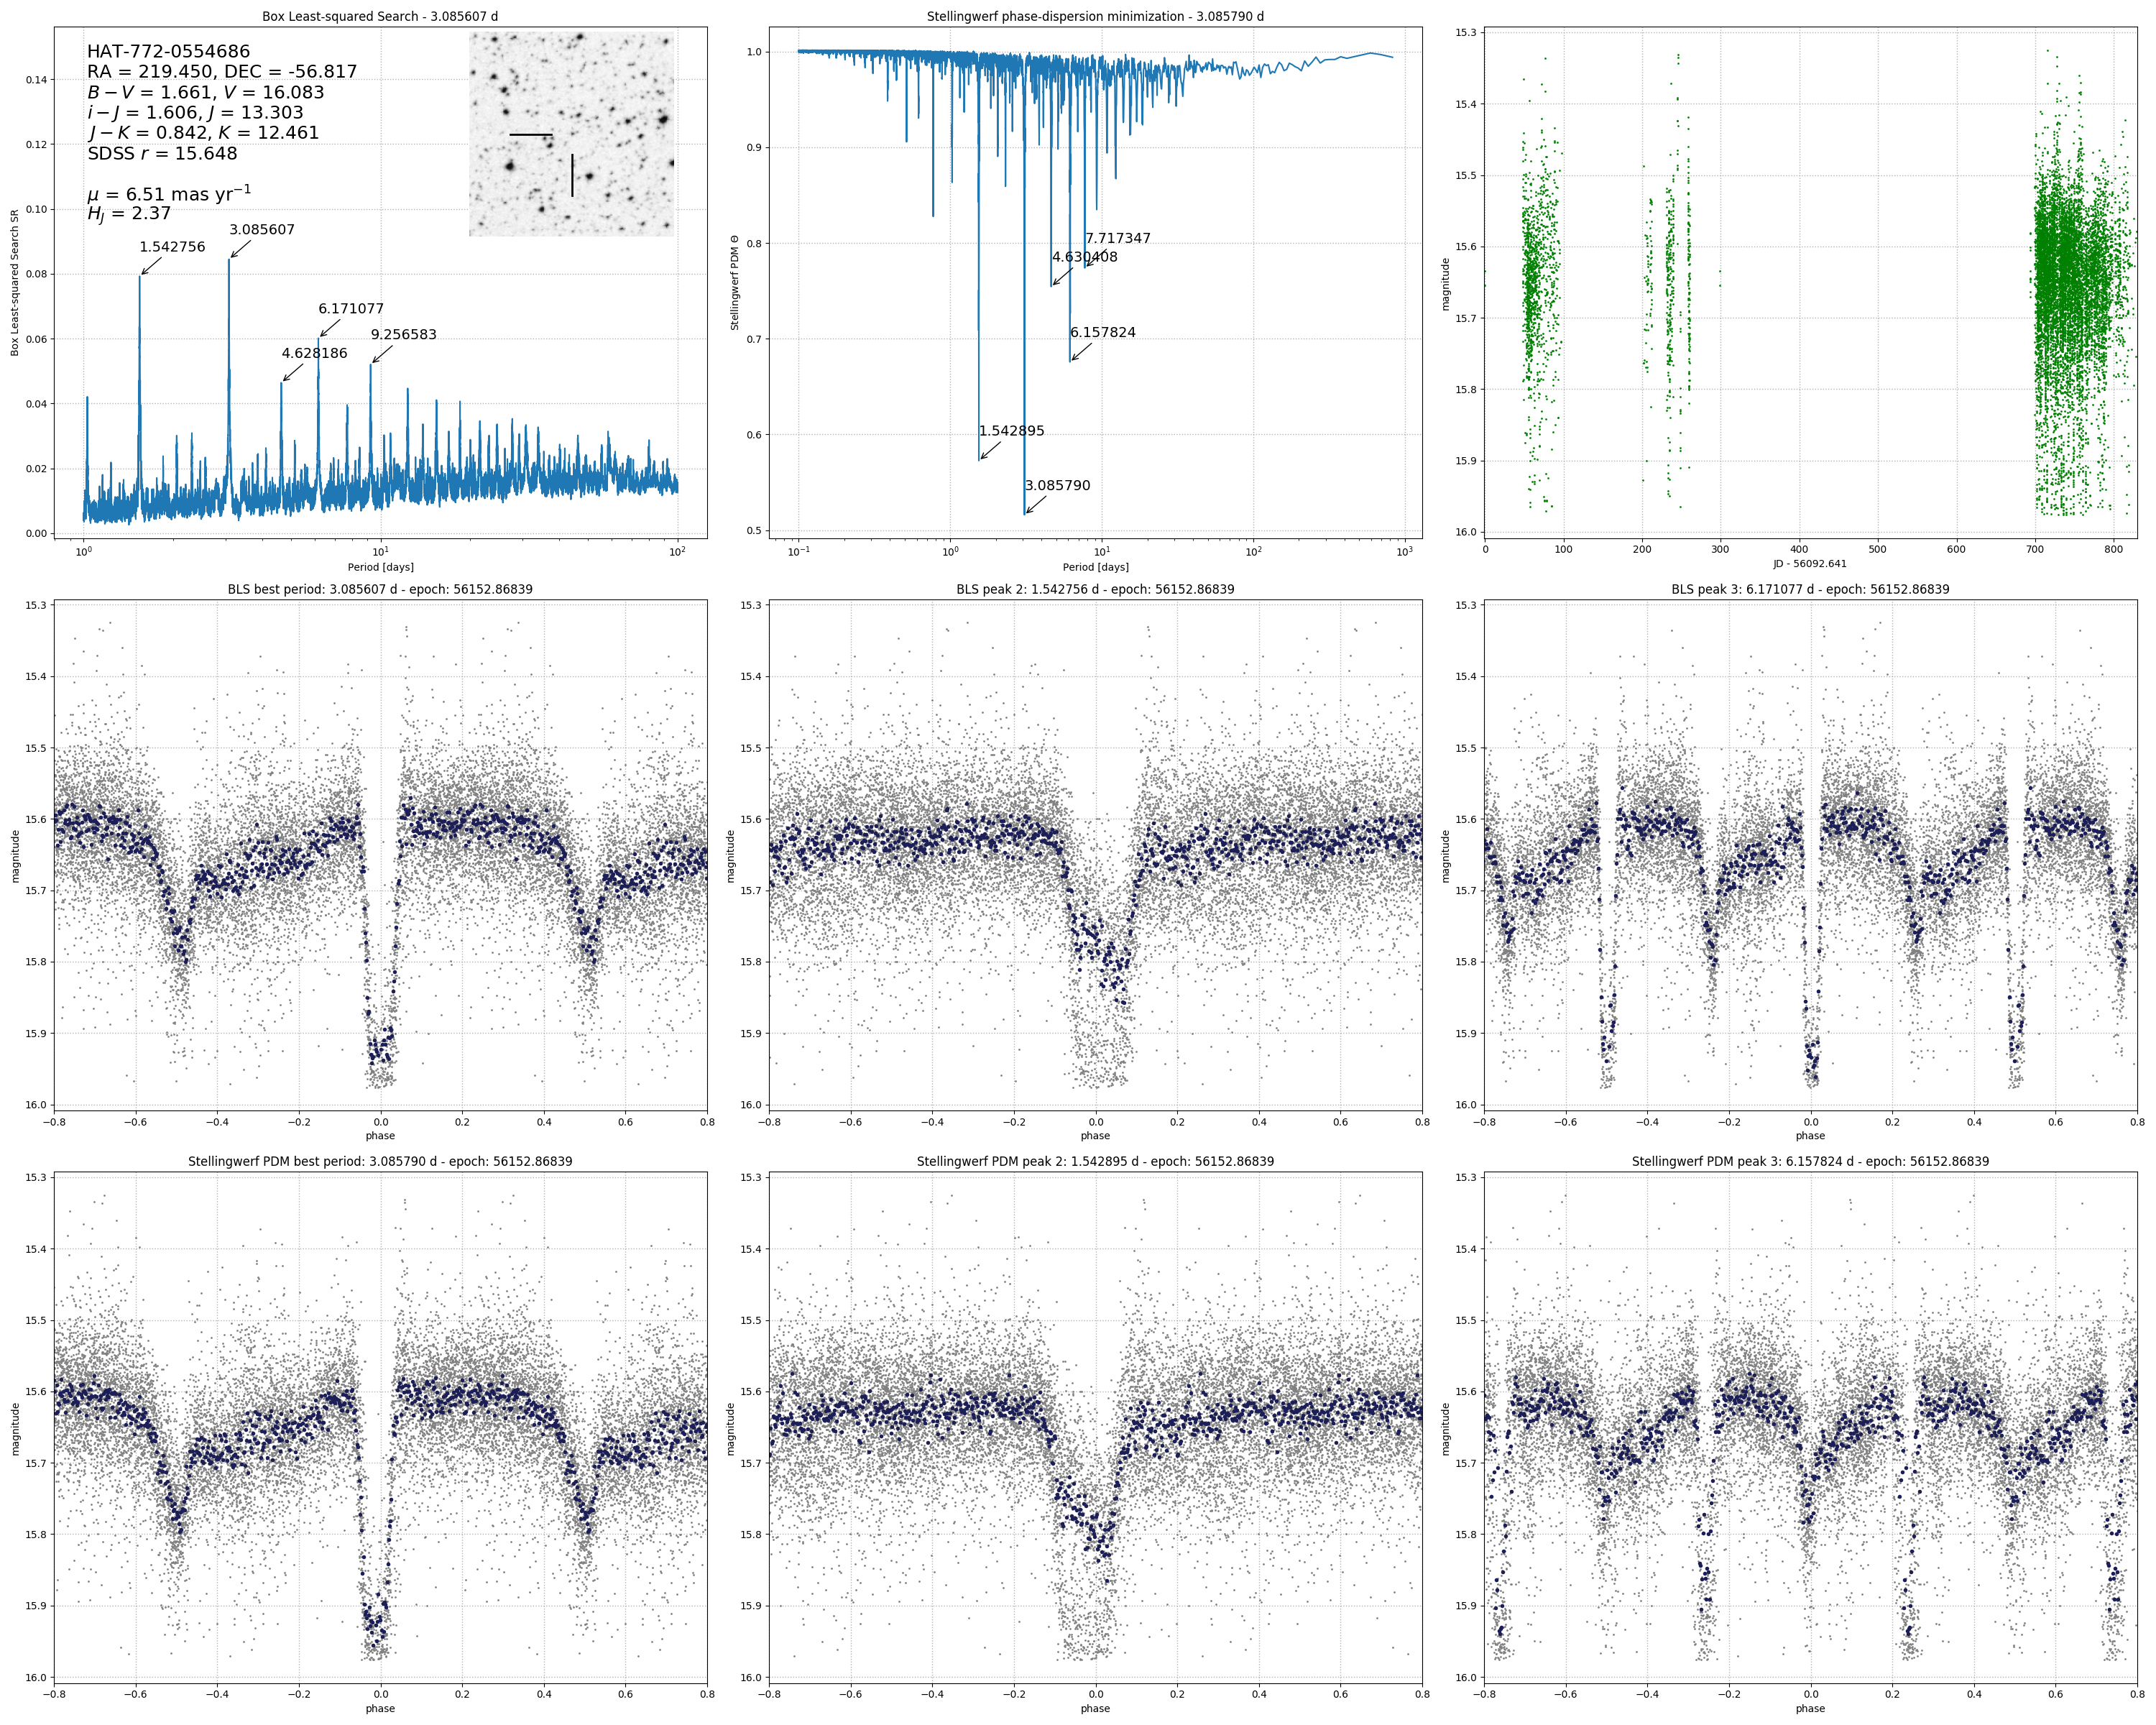

In [21]:
# let's use twolsp_checkplot_png to plot results from two independent
# period-finding routines at the same time. if the best periods match
# up between the two methods, we can be sure we've got the right period
cp = checkplot.twolsp_checkplot_png(blsp, spdm, times, mags, errs, objectinfo=normlcd['objectinfo'])
Image('twolsp-checkplot.png')